     Application       RFC       XGB       KNN
13       YouTube  0.847235  0.826373  0.741991
4           Hulu  0.837932  0.837674  0.721624
8        Pandora  0.829433  0.806141  0.739040
0        Dropbox  0.826243  0.844555  0.716427
12       Twitter  0.774605  0.754877  0.696406
11       Spotify  0.768241  0.780756  0.659212
10        Reddit  0.720930  0.706750  0.621206
7        Netflix  0.698558  0.699436  0.564100
3   Google Drive  0.667352  0.620614  0.458475
9      Pinterest  0.656701  0.654207  0.568252
5      Instagram  0.607730  0.607450  0.424835
2          Gmail  0.545453  0.534553  0.418209
1       Facebook  0.530474  0.484483  0.425020
6      Messenger  0.462191  0.458498  0.422588


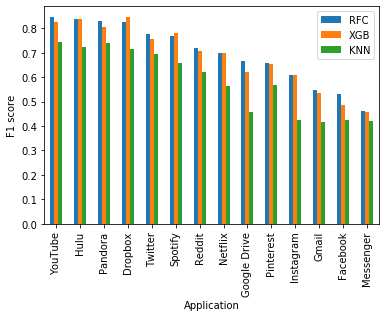

In [1]:
"""
@author: Yuqiang (Ethan) Heng
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

df = pd.read_csv('./Processed Data/random_scenario_bi_flow_features.csv',low_memory=False).dropna().drop('Unnamed: 0',axis=1)
dl_features = [f for f in df.columns.values if f.split('_')[0] == 'dl']
ul_features = [f for f in df.columns.values if f.split('_')[0] == 'ul']
features = np.concatenate((dl_features,ul_features))

rfc_f1_per_app = {app:[] for app in df['app'].unique()}
knn_f1_per_app = {app:[] for app in df['app'].unique()}
xgb_f1_per_app = {app:[] for app in df['app'].unique()}

num_apps = len(df['app'].unique())
X = df[dl_features]
scaler = StandardScaler()
X = scaler.fit_transform(X)
le = LabelEncoder()
Y = le.fit_transform(df['app'])
kfold = KFold(n_splits=10, shuffle = True, random_state=7)
for k, (train, test) in enumerate(kfold.split(X, Y)):
    rfc = RandomForestClassifier()
    rfc.fit(X[train], Y[train])
    rfc_predit = rfc.predict(X[test])
    rfc_report = classification_report(Y[test],rfc_predit,target_names=le.inverse_transform(np.arange(num_apps)),digits=3,output_dict=True)

    knn = KNeighborsClassifier()
    knn.fit(X[train], Y[train])
    knn_predit = knn.predict(X[test])
    knn_report = classification_report(Y[test],knn_predit,target_names=le.inverse_transform(np.arange(num_apps)),digits=3,output_dict=True)
    
    xgb = XGBClassifier()
    xgb.fit(X[train], Y[train])
    xgb_predit = xgb.predict(X[test])
    xgb_report = classification_report(Y[test],xgb_predit,target_names=le.inverse_transform(np.arange(num_apps)),digits=3,output_dict=True)
    
    for app_name in df['app'].unique():
        rfc_f1_per_app[app_name].append(rfc_report[app_name]['f1-score'])
        knn_f1_per_app[app_name].append(knn_report[app_name]['f1-score'])
        xgb_f1_per_app[app_name].append(xgb_report[app_name]['f1-score'])
        
app_names = {'youtube':'YouTube','spotify':'Spotify','dropbox':'Dropbox','pandora':'Pandora','hulu':'Hulu',
             'twitter':'Twitter','reddit':'Reddit','pinterest':'Pinterest','netflix':'Netflix','google-drive':'Google Drive',
             'instagram':'Instagram','facebook':'Facebook','gmail':'Gmail','messenger':'Messenger','hangout':'Hangout','google-maps':'Google Maps'}

plot_df = pd.DataFrame({'Application':[app_names[app_name] for app_name in df['app'].unique()],
                        'RFC':[np.array(rfc_f1_per_app[app_name]).mean() for app_name in df['app'].unique()],
                        'XGB':[np.array(xgb_f1_per_app[app_name]).mean() for app_name in df['app'].unique()],                        
                        'KNN':[np.array(knn_f1_per_app[app_name]).mean() for app_name in df['app'].unique()]})
plot_df = plot_df.sort_values(by='RFC',ascending=False)
print(plot_df)
plot_df.plot(x='Application',kind='bar',ylabel='F1 score',stacked=False)